# Use CellProfiler Features Extracted to Construct a knn Network

## Import data and split into training/test set

In [103]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv(r"..\data\processed\cellprofiler_data.csv")
data = raw_data.drop(["Phenotype", "ImageNumber"], axis=1)
labels = raw_data["Phenotype"]
data = data.to_numpy()
labels = labels.to_numpy()
phenotype = {"alveolar": 0,
             "marrow": 1,
             "monocyte": 2}
labels = [phenotype[label] for label in labels]

from random import shuffle
train_index = [[] for _ in range(len(phenotype))] 
test_index = [[] for _ in range(len(phenotype))]

[train_index[labels[i]].append(i) for i in range(len(labels))]

for i in range(len(train_index)):
    tmp = train_index[i]
    shuffle(tmp)

    test_len = int(len(tmp)/5)
    test_index[i].extend(tmp[:test_len])
    train_index[i] = tmp[test_len:]

tmp = []
[tmp.extend(inds) for inds in train_index]
train_index = tmp

train_samples = np.stack([data[ind] for ind in train_index])
train_labels = np.stack([labels[ind] for ind in train_index])

tmp = []
[tmp.extend(inds) for inds in test_index]
test_index = tmp

test_samples = np.stack([data[ind] for ind in test_index])
test_labels = np.stack([labels[ind] for ind in test_index])

## PCA of data

Explained variation per principal component: [0.61592763 0.31057646 0.01931509 0.01130353 0.01004533 0.00773539
 0.00537344 0.0041341  0.00333937 0.00260061]


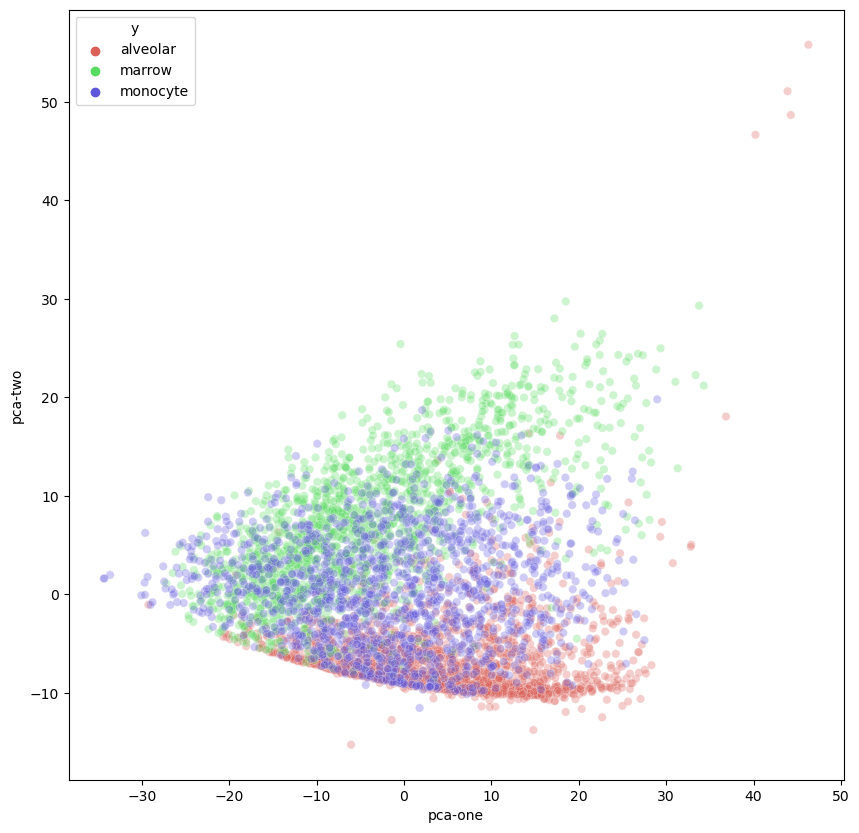

In [111]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train_samples)
std_data = sc.transform(train_samples)
std_test_data = sc.transform(test_samples)

num_comp = 10

pca = PCA(n_components=num_comp)
pca.fit(std_data)
pca_result = pca.transform(std_data)

graph_data = pd.DataFrame()
graph_data['pca-one'] = pca_result[:,0]
graph_data['pca-two'] = pca_result[:,1] 
graph_data['pca-three'] = pca_result[:,2]  

reverse_pheno = {v: k for k, v in phenotype.items()}

graph_data['y'] = [reverse_pheno[label] for label in train_labels]


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=graph_data,
    legend="full",
    alpha=0.3
)
plt.show()

## T-SNE of Data

In [ ]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=50, n_iter=5000, learning_rate=200)

tsne_results = TSNE.fit_transform(pca_result)

In [ ]:
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['t-sne-one', 't-sne-two'])
df_tsne['label'] = [reverse_pheno[label] for label in train_labels]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="t-sne-one", y="t-sne-two",
    hue="label",
    palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full",
    alpha=0.5
)
plt.show()

## KNN (K Nearest Neighbors) with standardized raw data

In [112]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=len(phenotype))
knn.fit(std_data, train_labels)

out = list(knn.predict(std_test_data))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of knn: {accuracy:>0.2%}")

num_classes = max(out) + 1

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)
print("alveolar", "marrow", "monocyte")

accuracy of knn: 73.44%
[[0.74950298 0.03777336 0.21272366]
 [0.02836879 0.79196217 0.17966903]
 [0.22418879 0.13569322 0.64011799]]
alveolar marrow monocyte


## Using PCA modified dataset with KNN

Sometimes features that are not correlated with the correct class is detrimental to KNN. Using PCA dimensionality reduction we try to filter these out.

In [113]:
knn_pca = KNeighborsClassifier(n_neighbors=len(phenotype))
knn_pca.fit(pca_result, train_labels)

pca_test_data = pca.transform(std_test_data)

out = list(knn_pca.predict(pca_test_data))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of PCA knn: {accuracy:>0.2%}")

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)
print("alveolar", "marrow", "monocyte")


accuracy of PCA knn: 73.12%
[[0.73166023 0.04247104 0.22586873]
 [0.0258216  0.79577465 0.17840376]
 [0.23364486 0.12149533 0.64485981]]
alveolar marrow monocyte


## Random forest with raw data

In [115]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(pca_result, train_labels)

out = list(rfc.predict(pca_test_data))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of random forest: {accuracy:>0.2%}")

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)
print("alveolar", "marrow", "monocyte")

accuracy of random forest: 78.10%
[[0.8        0.028      0.172     ]
 [0.0230179  0.83887468 0.13810742]
 [0.14973262 0.15508021 0.69518717]]
alveolar marrow monocyte


## Random forest with extracted features

In [116]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(pca_result, train_labels)

out = list(rfc.predict(pca_test_data))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of pca random forest: {accuracy:>0.2%}")

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)
print("alveolar", "marrow", "monocyte")

accuracy of random forest: 77.94%
[[0.7972167  0.02385686 0.17892644]
 [0.02077922 0.84675325 0.13246753]
 [0.14854111 0.16445623 0.68700265]]
alveolar marrow monocyte
